In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
covid = pd.read_csv('covid_train.csv')
covid.columns=['Age','Gender','Acq','City','Outbreak','Lat','Long','Outcome']
covid.head()

,Age,Gender,Acq,City,Outbreak,Lat,Long,Outcome
0,50s,MALE,NO KNOWN EPI LINK,Oakville,NaN,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,NaN,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal


### Missing Value

In [25]:
covid.isna().sum()

Age            6
Gender         0
Acq            0
City           0
Outbreak    9020
Lat            0
Long           0
Outcome        0
dtype: int64

In [26]:
# Age only has 6 missing values, relatively small amount, just delete
covid = covid.dropna(subset=['Age'])

In [27]:
# The NA in Outbreak will be replaced as "No" 
covid = covid.fillna(value={"Outbreak":"No"})

In [28]:
covid.isna().sum()

Age         0
Gender      0
Acq         0
City        0
Outbreak    0
Lat         0
Long        0
Outcome     0
dtype: int64

### Change categorical value into numeric

1. Age group here is an ordinary variable (has ranking), the order of numbers have information for age, so it should not be one-hot encoded.

In [29]:
covid.Age.unique()

array(['50s', '20s', '90s', '60s', '70s', '30s', '80s', '<20', '40s'],
      dtype=object)

In [30]:
covid.Age = pd.np.where(covid.Age == '<20', 1,
                       pd.np.where(covid.Age == '20s',2,
                                  pd.np.where(covid.Age == '30s',3,
                                             pd.np.where(covid.Age == '40s',4,
                                                        pd.np.where(covid.Age == '50s',5,
                                                                   pd.np.where(covid.Age == '60s',6,
                                                                              pd.np.where(covid.Age == '70s',7,
                                                                                         pd.np.where(covid.Age == '80s',8,9))))))))

In [31]:
covid.Age.unique()

array([5, 2, 9, 6, 7, 3, 8, 1, 4])

2. Gender here is a norminal variable which has four catefories, we will use one-hot encoding to transform it into numeric value.

Since there only 2 records of "Gender Diverse", we included them into "Unspecified".

In [32]:
covid.Gender.unique()

array(['MALE', 'FEMALE', 'UNSPECIFIED', 'GENDER DIVERSE'], dtype=object)

In [33]:
covid.Gender = pd.np.where(covid.Gender == 'GENDER DIVERSE', 'UNSPECIFIED', covid.Gender)

In [34]:
Gender_dum = pd.get_dummies(covid.Gender, prefix = "Gender")

3. Case Aquisition info is a norminal value here which has 6 categories, we will transform it with one-hot encoding.

In [35]:
covid.Acq.unique()

array(['NO KNOWN EPI LINK', 'CC', 'OB', 'MISSING INFORMATION', 'TRAVEL',
       'UNSPECIFIED EPI LINK'], dtype=object)

In [36]:
Acq_dum = pd.get_dummies(covid.Acq, prefix = "Acq")

4. City is a norminal variable here which has 34 categories, we will transform them with one-hot encoding

In [37]:
covid['City'].unique() 

array(['Oakville', 'Guelph', 'Barrie', 'Toronto', 'Ottawa', 'Newmarket',
       'Thorold', 'Whitby', 'Windsor', 'Waterloo', 'Mississauga',
       'New Liskeard', 'Simcoe', 'Hamilton', 'Thunder Bay', 'London',
       'Point Edward', 'St. Thomas', 'Kingston', 'Cornwall', 'Port Hope',
       'North Bay', 'Stratford', 'Owen Sound', 'Brantford', 'Chatham',
       'Brockville', 'Timmins', 'Kenora', 'Sudbury', 'Belleville',
       'Peterborough', 'Sault Ste. Marie', 'Pembroke'], dtype=object)

In [38]:
City_dum = pd.get_dummies(covid.City, prefix = "City")

5. Ourbreak is a binary value, we will transform it with one-hot encoding

In [39]:
Outbreak_dum = pd.get_dummies(covid.Outbreak, prefix = "Outbreak")

### Dividing dataset

In [40]:
from sklearn import model_selection

covid = pd.concat([covid,Gender_dum,Acq_dum,City_dum,Outbreak_dum], axis = 1)
covid = covid.drop(columns = ['Gender', 'Acq','City','Outbreak'])

In [41]:
X_all = covid.drop(columns = ['Outcome'])
y_all = covid['Outcome']

In [42]:
print(len(X_all), len(y_all))

14845 14845


In [43]:
X, X_test, y, y_test = model_selection.train_test_split(X_all, y_all, train_size=0.8, random_state=275)

### 10 Fold Cross Validation

In [44]:
kfold = model_selection.KFold(n_splits = 10)

### Decision Trees

In [45]:
from sklearn import tree

In [46]:
dep_list = [3,5,10,None]
acc_list = []

for dep in dep_list:
    
    DecTree = tree.DecisionTreeClassifier(max_depth = dep, random_state = 0)
    acc = model_selection.cross_val_score(DecTree, X, y, cv=kfold)
    acc_list.append(acc.mean().round(4))

In [47]:
AccTable = pd.DataFrame(data={'Accuracy':acc_list, 'Max Depth of Trees':dep_list})
print(AccTable)

   Accuracy  Max Depth of Trees
0    0.6501                 3.0
1    0.6570                 5.0
2    0.6573                10.0
3    0.6447                 NaN


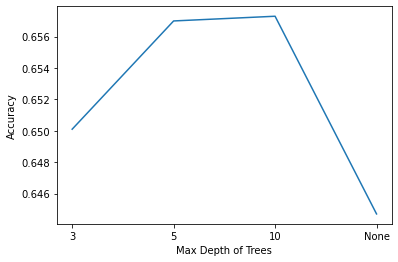

In [48]:
plt.plot(['3','5','10','None'], acc_list)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth of Trees')
plt.show()

For Decision Trees, the best classfier is when Max Depth of Trees set as 10, and the corresponding Mean of Accuracy = 65.73%

#### Splitting rules

In [49]:
from sklearn.tree import export_text
model = tree.DecisionTreeClassifier(max_depth = 5, random_state = 0).fit(X,y)

tree_rules = export_text(model, feature_names=list(X.columns))

In [50]:
print(tree_rules)

|--- Age <= 6.50
|   |--- Acq_MISSING INFORMATION <= 0.50
|   |   |--- Age <= 5.50
|   |   |   |--- Long <= -79.42
|   |   |   |   |--- Acq_OB <= 0.50
|   |   |   |   |   |--- class: Resolved
|   |   |   |   |--- Acq_OB >  0.50
|   |   |   |   |   |--- class: Not Resolved
|   |   |   |--- Long >  -79.42
|   |   |   |   |--- Acq_OB <= 0.50
|   |   |   |   |   |--- class: Resolved
|   |   |   |   |--- Acq_OB >  0.50
|   |   |   |   |   |--- class: Resolved
|   |   |--- Age >  5.50
|   |   |   |--- Acq_OB <= 0.50
|   |   |   |   |--- Long <= -79.43
|   |   |   |   |   |--- class: Resolved
|   |   |   |   |--- Long >  -79.43
|   |   |   |   |   |--- class: Resolved
|   |   |   |--- Acq_OB >  0.50
|   |   |   |   |--- Outbreak_No <= 0.50
|   |   |   |   |   |--- class: Fatal
|   |   |   |   |--- Outbreak_No >  0.50
|   |   |   |   |   |--- class: Not Resolved
|   |--- Acq_MISSING INFORMATION >  0.50
|   |   |--- City_Toronto <= 0.50
|   |   |   |--- City_Newmarket <= 0.50
|   |   |   |   |-

As it is known, greedy algorithmn and purity(GINI) is used in sklearn to decide the rules of splitting. 

In this case, "Age" is the first criterion used to split, which means "age" is the best feature to correctly label the target feature. In the mean time, "City" is the last one used to split, which means if we are using "city" to label the "outcome", we are not expecting a good result.

Besides, for the "Age group > 6.5, "Outbreak" is the next feature to split, which means elder people(>65 yo) living in the outbreak city are more likely to be affected by COVID. On the other hand, it seems that younger peope(<65 yo) are not likely to be affected even if living in an outbreak city.

In the tree of Age group <6.5, next important criterion is "Acquisition channel", whether people are getting the virus from community transition( if Acq_MISSING INFORMATION >0.5) is critical to young people(<65 yo). This indicates that among young people, community transition plays a very important role and it is a more important factor than it to senior people. 



### Performance on Test 

In [51]:
from sklearn import metrics

DecTree = tree.DecisionTreeClassifier(max_depth = 10, random_state = 0)
DecTree.fit(X,y)
y_pred = DecTree.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred).round(2)
print('Accuracy:', acc)

Accuracy: 0.66


And the model with tuned parameters have an accuracy of 0.66 while evaluating the test set.

### Random Forests

In [52]:
from sklearn import ensemble

In [53]:
dep_list = [3,5,10,None]
n_list = [5,10,50,150,200]
acc_list = []
dep_new = []
n_new=[]

for dep in dep_list:
    for n in n_list:
    
        RanFore = ensemble.RandomForestClassifier(max_depth = dep, n_estimators = n, random_state = 0 )
        acc = model_selection.cross_val_score(RanFore, X, y, cv=kfold)
        acc_list.append(acc.mean().round(4))
        dep_new.append(dep)
        n_new.append(n)

In [54]:
AccTable = pd.DataFrame(data={'Accuracy':acc_list, 'Max Depth of Trees':dep_new, "Number of Trees":n_new})
print(AccTable)

    Accuracy  Max Depth of Trees  Number of Trees
0     0.5891                 3.0                5
1     0.6034                 3.0               10
2     0.6130                 3.0               50
3     0.6197                 3.0              150
4     0.6234                 3.0              200
5     0.6327                 5.0                5
6     0.6283                 5.0               10
7     0.6391                 5.0               50
8     0.6415                 5.0              150
9     0.6428                 5.0              200
10    0.6607                10.0                5
11    0.6627                10.0               10
12    0.6663                10.0               50
13    0.6669                10.0              150
14    0.6668                10.0              200
15    0.6457                 NaN                5
16    0.6477                 NaN               10
17    0.6482                 NaN               50
18    0.6488                 NaN              150


For Random Forests, the best classfier is when Max Depth of Trees set as 10, Number of Trees set as 150, and the corresponding Mean of Accuracy = 66.69%

In [55]:
AccTable['Max Depth of Trees'] = pd.np.where(AccTable['Max Depth of Trees'] == 'NaN', 'None', AccTable['Max Depth of Trees'])

In [56]:
import seaborn as sns

<AxesSubplot:xlabel='Max Depth of Trees', ylabel='Number of Trees'>

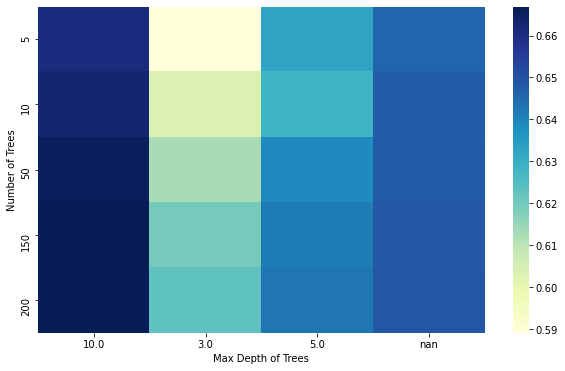

In [57]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.pivot_table(AccTable, values='Accuracy', 
                     index=['Number of Trees'], 
                     columns=['Max Depth of Trees']),
           cmap="YlGnBu")

### Performance on Test 

In [69]:
RanFore = ensemble.RandomForestClassifier(max_depth = 10, n_estimators = 150, random_state = 0)
RanFore.fit(X,y)
y_pred = RanFore.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred).round(2)
print('Accuracy:', acc)

Accuracy: 0.68


The model with tuned parameters have an accuracy of 0.68 while evaluating the test set.

### Gradient Boosting

In [59]:
n_list = [5,10,50,150,200]
acc_list = []

for n in n_list:
    
    GradBoo = ensemble.GradientBoostingClassifier(n_estimators = n, random_state = 0 )
    acc = model_selection.cross_val_score(GradBoo, X, y, cv=kfold)
    acc_list.append(acc.mean().round(5))

In [60]:
AccTable = pd.DataFrame(data={'Accuracy':acc_list, 'Number of Trees':n_list})
print(AccTable)

   Accuracy  Number of Trees
0   0.65830                5
1   0.65957               10
2   0.66454               50
3   0.66504              150
4   0.66428              200


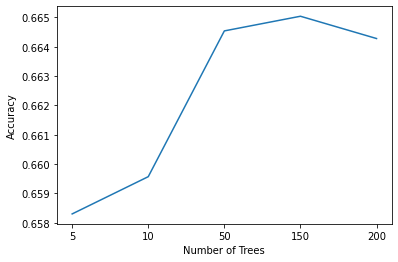

In [61]:
plt.plot(['5','10','50','150','200'], acc_list)
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.show()

### Performance on Test 

In [62]:
GradBoo = ensemble.GradientBoostingClassifier(n_estimators = 150, random_state = 0 )
GradBoo.fit(X,y)
y_pred = GradBoo.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred).round(2)
print('Accuracy:', acc)

Accuracy: 0.68


So the model with tuned parameters have an accuracy of 0.68 while evaluating the test set.

For Gradient Boosting, the best classfier is when Number of Trees set as 150, and the according Mean of Accuracy = 66.50%

GBT will usually perform better, but they are hard to get right since too many hyper-parameteres to tune, and easily to overfit
as what happend in seeds dataset.

The popularity of Random Forest is primarily due to how well it performs in a multitude of data situations. 
It tends to handle highly correlated features well, where as a linear regression model would not. 
In this case, we demonstrate the performance ability even with only a few features and almost all of them 
being highly correlated with each other.

Decision Tree depend highly on specific set of features. So in most cases, Decision Tree can not generalize over 
the data in a better way. However it is easier to interpret, like the splittng rules plotted. Besides, since only 
one tree is generated, the time consuming is much less than GBT and Random Forest. That can be crucial when we are 
working with a tight deadline in a ml project.

For the seeds dataset, it is a relatively small dataset, we can see that a more complex model cannot confirmly make sure the performance is better.(all around 90% accuracy) Plus more complex models may lead to overfitting, for small datasets in the future, it might be better to choose some simple models which have a faster running time and also can achieve a fair performance.

For the covid dataset, we can see that Ensemble methods achieve higher performances than decision tree itself, which is within our expectation. 

### Naive Bayes

In [63]:
from sklearn import naive_bayes 

In [64]:
var_list = [1e-10,1e-9,1e-5,1e-3,1e-1]
acc_list = []

for var in var_list:
    
    NB = naive_bayes.GaussianNB(var_smoothing = var )
    acc = model_selection.cross_val_score(NB, X, y, cv=kfold)
    acc_list.append(acc.mean().round(4))

In [65]:
AccTable = pd.DataFrame(data={'Accuracy':acc_list, 'Var Smoothing':var_list})
print(AccTable)

   Accuracy  Var Smoothing
0    0.3835   1.000000e-10
1    0.4046   1.000000e-09
2    0.5709   1.000000e-05
3    0.6077   1.000000e-03
4    0.6500   1.000000e-01


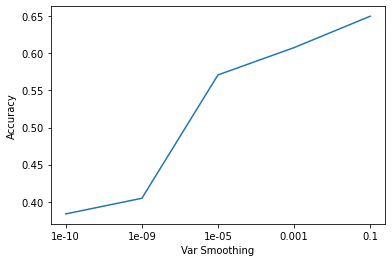

In [66]:
plt.plot(list(map(str,var_list)), acc_list)
plt.ylabel('Accuracy')
plt.xlabel('Var Smoothing')
plt.show()

For Gaussian Naive Bayes, the best classfier is when Var Smoothing set as 0.1, and the according Mean of Accuracy = 65%.

var_smmoothing stands for the portion of the largest variance of all features that is added to variances for calculation stability.This essentially smooths the curve and accounts for more samples that are further away from the distribution mean.

### Performance on Test

In [68]:
NB = naive_bayes.GaussianNB(var_smoothing = 0.1)
NB.fit(X,y)
y_pred = NB.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred).round(2)
print('Accuracy:', acc)

Accuracy: 0.66


So the model with tuned parameters have an accuracy of 0.66 while evaluating the test set.

### Part 2

For seed dataset, NB performs better than Decision Tree. This is partly because GaussianNB works better in feature
with continous data and when the dataset is small. Since we assume the seed dataset is described by the Gaussian distribution with no co-variance 
between features. This model can be fit by simply finding the mean and standard deviation of the points within each
label, which is all what is needed to define such a distribution.

For COVID dataset, Decision Tree is a bit better than NB since the input features are not all continous data. 
Using Hot-encoding add lots of non-continous features to the inputs. Besides, there are abundant features in the 
inputs, which may make other model outperforms NB

Decision trees are more flexible than NB. Besides, Decision Tree pruning may neglect some key values in training data,
which can lead the accuracy for a toss.
On the other hand, NB is a generative model while Decision Tree is a discriminative model.

### Test

In [92]:
test = pd.read_csv('covid_tests.csv')
test = test.drop(columns=['id'])
test.columns=['Age','Gender','Acq','City','Outbreak','Lat','Long']
test.head()

,Age,Gender,Acq,City,Outbreak,Lat,Long
0,80s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358
1,80s,MALE,NO KNOWN EPI LINK,Toronto,Yes,43.656591,-79.379358
2,40s,FEMALE,OB,Stratford,Yes,43.368662,-81.001913
3,30s,MALE,NO KNOWN EPI LINK,Mississauga,NaN,43.647471,-79.708893
4,60s,MALE,NO KNOWN EPI LINK,London,NaN,42.981468,-81.254016


In [93]:
test.isna().sum()

Age            0
Gender         0
Acq            0
City           0
Outbreak    2288
Lat            0
Long           0
dtype: int64

In [94]:
# The NA in Outbreak will be replaced as "No" 
test = test.fillna(value={"Outbreak":"No"})

In [95]:
test.Age = pd.np.where(test.Age == '<20', 1,
                       pd.np.where(test.Age == '20s',2,
                                  pd.np.where(test.Age == '30s',3,
                                             pd.np.where(test.Age == '40s',4,
                                                        pd.np.where(test.Age == '50s',5,
                                                                   pd.np.where(test.Age == '60s',6,
                                                                              pd.np.where(test.Age == '70s',7,
                                                                                         pd.np.where(test.Age == '80s',8,9))))))))

In [96]:
test.Gender = pd.np.where(test.Gender == 'GENDER DIVERSE', 'UNSPECIFIED', test.Gender)

In [97]:
Gender_dum = pd.get_dummies(test.Gender, prefix = "Gender")

In [98]:
Acq_dum = pd.get_dummies(test.Acq, prefix = "Acq")

In [99]:
## train has 38 cities, test has 36 cities

City_dum = pd.get_dummies(test.City, prefix = "City")

In [100]:
Outbreak_dum = pd.get_dummies(test.Outbreak, prefix = "Outbreak")

In [101]:
test = pd.concat([test,Gender_dum,Acq_dum,City_dum,Outbreak_dum], axis = 1)
test = test.drop(columns = ['Gender', 'Acq','City','Outbreak'])

In [102]:
test['Sault Ste. Marie'] = 0

In [103]:
test['Pembroke'] = 0

In [104]:
test.head()

,Age,Lat,Long,Gender_FEMALE,Gender_MALE,Gender_UNSPECIFIED,Acq_CC,Acq_MISSING INFORMATION,Acq_NO KNOWN EPI LINK,Acq_OB,...,City_Thunder Bay,City_Timmins,City_Toronto,City_Waterloo,City_Whitby,City_Windsor,Outbreak_No,Outbreak_Yes,Sault Ste. Marie,Pembroke
0,8,43.656591,-79.379358,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,8,43.656591,-79.379358,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,4,43.368662,-81.001913,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,3,43.647471,-79.708893,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,6,42.981468,-81.254016,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [108]:
# model = ensemble.RandomForestClassifier(max_depth = 10, n_estimators = 200, random_state = 0 )
model = ensemble.GradientBoostingClassifier(n_estimators = 50, random_state = 0 )
model.fit(X, y)
pred = model.predict(test)

In [109]:
output = pd.DataFrame({'id':list(range(len(pred))), 'Outcome1':pred})

In [110]:
output.to_csv('covid_result3.csv', index=False)

In [111]:
# RF: 10,150 - 0.81054, 10,200- 0.81122
# GB: 0.80437